# Investigating Cov. Shift and Concept Drift in time

In [1]:
from functions import *

Number of processors:  80


In [2]:
ids0=list(pd.read_csv('data/ids_t0.csv').ndoc)
parts = partition(ids0.copy(), m)

In [3]:
cpus=20

In [4]:
data={}

for i in tqdm(range(m)):
    X=pd.read_csv('data/X_t'+str(i)+'.csv').iloc[:,:num_feat[-1]]
    y=pd.read_csv('data/y_t'+str(i)+'.csv')
    ids=list(pd.read_csv('data/ids_t'+str(i)+'.csv').ndoc)
    
    pool = mp.Pool(cpus)
    ind = np.array(pool.starmap(check, [(j, parts[i]) for j in ids]))
    pool.close()
    
    X=X.loc[ind,:] 
    y=y.loc[ind]

    ind=np.mean((X==-2) | (X==-1), axis=1)<.75
    X=X.loc[ind,:].reset_index(drop=True) 
    y=y.loc[ind].reset_index(drop=True)
    
    if i==0:
        n=X.shape[0]

    X=X.iloc[:n,:]
    y=y.iloc[:n]
    
    data[i]={'X': X,'y': y}

100%|██████████| 10/10 [34:33<00:00, 207.31s/it]


In [5]:
for i in range(m):
    print('Month={:}, X.shape={:}'.format(i+1, data[i]['X'].shape))

Month=1, X.shape=(54368, 75)
Month=2, X.shape=(54368, 75)
Month=3, X.shape=(54368, 75)
Month=4, X.shape=(54368, 75)
Month=5, X.shape=(54368, 75)
Month=6, X.shape=(54368, 75)
Month=7, X.shape=(54368, 75)
Month=8, X.shape=(54368, 75)
Month=9, X.shape=(54368, 75)
Month=10, X.shape=(54368, 75)


In [6]:
%%time
B=75

pool = mp.Pool(cpus)
out = pool.starmap(simulation, [(b, data) for b in range(B)])
pool.close()

1
2
3
5
10
15
25
50
75
CPU times: user 36.4 s, sys: 59.2 s, total: 1min 35s
Wall time: 3h 55min 20s


In [7]:
#(simulations, shift_est/err, num_feat, total/cov/conc, months)
out=np.array(out)
out.shape

(75, 2, 9, 3, 10)

In [8]:
np.save('outputs_comp_diff_notuning.npy', out) 

In [9]:
out = np.load('outputs_comp_diff_notuning.npy', allow_pickle='TRUE')

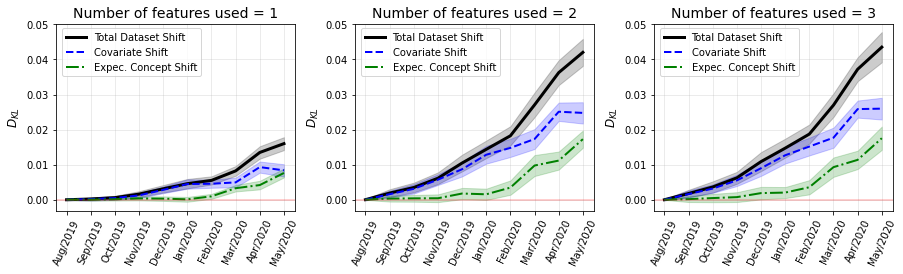

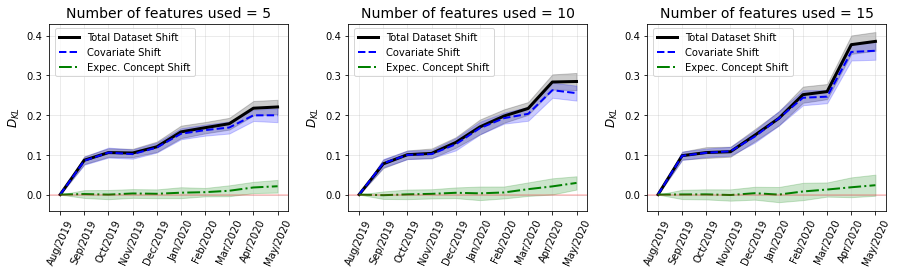

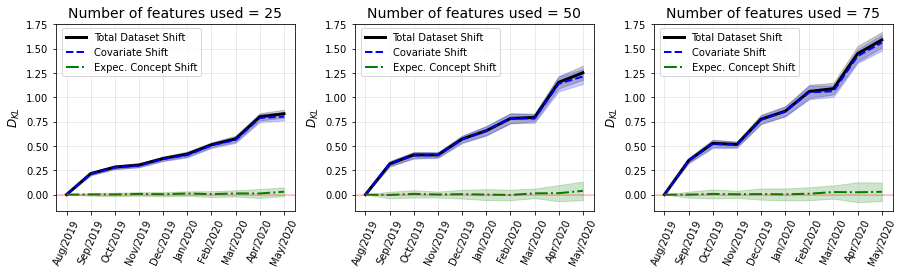

In [10]:
for j in range(3):
    
    fig, axs = plt.subplots(1, 3, sharey=True)
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.25   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

    for i in range(3):
        
        f=3*j+i
        total_mean, conc_mean, cov_mean = [np.mean(out[:, 0, f, shift, :], axis=0) for shift in range(3)]
        total_std, conc_std, cov_std = [np.std(out[:, 0, f, shift, :], axis=0) for shift in range(3)]
        
        #
        axs[i].plot(np.arange(m), total_mean, color='k', ls='-', lw=3, label='Total Dataset Shift')
        axs[i].fill_between(np.arange(m), total_mean-total_std, total_mean+total_std, color='k', alpha=0.2)
        axs[i].plot(np.arange(m), cov_mean, color='b', ls='--', lw=2, label='Covariate Shift')
        axs[i].fill_between(np.arange(m), cov_mean-cov_std, cov_mean+cov_std, color='b', alpha=0.2)
        axs[i].plot(np.arange(m), conc_mean, color='g', ls='-.', lw=2, label='Expec. Concept Shift')
        axs[i].fill_between(np.arange(m), conc_mean-conc_std, conc_mean+conc_std, color='g', alpha=0.2)
        axs[i].axhline(y=0, color='r', linestyle='-', lw=1.5, alpha=.25)
        #
        
        axs[i].legend(bbox_to_anchor=(.025, .975), loc='upper left', borderaxespad=.0)
        axs[i].set_title('Number of features used = '+str(num_feat[3*j+i]), size=14)
        #axs[i].set_xlabel('Months', size=12)
        axs[i].set_ylabel("$D_{KL}$", size=12)
        axs[i].set_xticks([0,1,2,3,4,5,6,7,8,9])
        axs[i].set_xticklabels(['Aug/2019', 'Sep/2019', 'Oct/2019', 'Nov/2019', 'Dec/2019','Jan/2020', 'Feb/2020', 'Mar/2020', 'Apr/2020', 'May/2020'], rotation=65)
        axs[i].grid(alpha=.3)
        axs[i].yaxis.set_tick_params(which='both', labelbottom=True)
 
    fig.set_figheight(3.25)
    fig.set_figwidth(15)
    plt.savefig('plots/decomp_credit'+str(j)+'_comp_diff_notuning.png', bbox_inches='tight', dpi=300, transparent=True)